In [1]:
import scSpace
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np
import pandas as pd
import random
import torch
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

/home/qjy/anaconda3/envs/scspace_dev/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    
setup_seed(123)

In [3]:
sc_data_dir = 'data/st_data_p2_r2.csv'
sc_meta_dir = 'data/st_meta_p2_r2.csv'
st_data_dir = 'data/st_data_p2_r1.csv'
st_meta_dir = 'data/st_meta_p2_r1.csv'

sc_obj, st_obj = scSpace.load_data(
    sc_data_path=sc_data_dir, sc_meta_path=sc_meta_dir, 
    st_data_path=st_data_dir, st_meta_path=st_meta_dir,
    spatial_key=['x','y'])

Loading data...
Data have been loaded.


In [4]:
sc_obj_hvg, st_obj_hvg = scSpace.preporcess(sc_adata=sc_obj, st_adata=st_obj, st_type='spot', n_features=2000, normalize=True, select_hvg='union')

Data have been pre-processed.


In [5]:
sc_obj_hvg, st_obj_hvg = scSpace.construct_pseudo_space(
    sc_adata=sc_obj_hvg,
    st_adata=st_obj_hvg,
    batch_size=16,
    activation='sigmoid',
    lr=0.001,
    epoch_num=1000,
    log_epoch=1000)

Beginning Transfer Component Analysis...
Transfer Component Analysis done.
Beginning training encoder for source domain...


100%|██████████| 1000/1000 [00:35<00:00, 27.98it/s]

Epoch [1000/1000]: Batch loss=26.918020248413086
Encoder for source domain training finished.


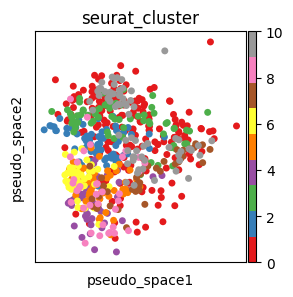

In [10]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(sc_obj_hvg, basis="pseudo_space", color='seurat_cluster', cmap='Set1',s=100)

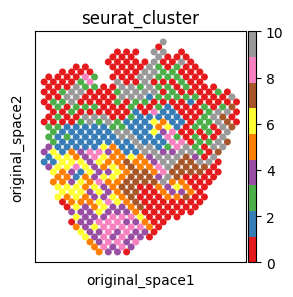

In [11]:
sc_obj_hvg.obsm['original_space'] = np.array(sc_obj_hvg.obs[['x', 'y']])
sc.pl.embedding(sc_obj_hvg, basis='original_space', color='seurat_cluster', cmap='Set1',s=100)

In [12]:
from scipy.stats import pearsonr
pseudo_dist = scSpace.cal_dist(sc_obj_hvg.obsm['pseudo_space'])
real_dist = scSpace.cal_dist(sc_obj_hvg.obsm['original_space'])
pearson = round(pearsonr(pseudo_dist, real_dist)[0], 3)
print('PCC = ', pearson)

100%|██████████| 646/646 [00:00<00:00, 1555.85it/s]

PCC =  0.647


<AxesSubplot: >

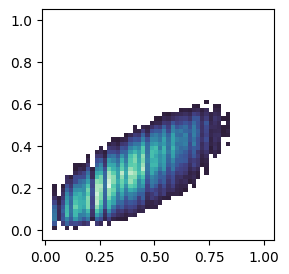

In [13]:
sns.histplot(x=real_dist, y=pseudo_dist, bins=50, pthresh=.1, cmap="mako")